<h1><a>LGD and EAD Model</a></h1>

<h2><a id="index">Index</a></h2>

[1. Import Data](#importdata)

[2. Explore Data](#exploredata)

[3. Model Variables](#modelvars)

[4. Explore Dependent Variables](#exploredepvars)

[5. LGD Model](#lgdmodel)

[6. EAD Model](#eadmodel)

[7. Expected Loss](#expectedloss)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stat
import seaborn as sns
import pickle
sns.set()

<h2><a id="importdata">1. Import Data</a></h2>

[Index](#index)

In [2]:
# Import data.
loan_data_preprocessed_backup = pd.read_csv('../Data/loan_data_2007_2014_preprocessed.csv')

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (21,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()
loan_data_preprocessed.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [4]:
loan_data_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


<h2><a id="exploredata">2. Explore Data</a></h2>

[Index](#index)

In [5]:
# Here we take only the accounts that were charged-off (written-off).
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin([
    'Charged Off','Does not meet the credit policy. Status:Charged Off'])]
loan_data_defaults.shape

(43236, 209)

In [6]:
pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

In [7]:
loan_data_defaults.isnull().sum()

Unnamed: 0                                                             0
Unnamed: 0.1                                                           0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                         

<h2><a id="modelvars">3. Model Variables</a></h2>

[Index](#index)

[3.1 Independent Variables](#modelvarsindep)

[3.2 Dependent Variables](#modelvarsdep)

<h3><a id="modelvarsindep">3.1 Independent Variables</a></h3>

[Top](modelvars)

In [8]:
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
# We fill the missing values with zeroes.

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [9]:
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)
# We fill the missing values with zeroes.

<h3><a id="modelvarsdep">3.2 Dependent Variables</a></h3>

[Top](modelvars)

In [10]:
# We calculate the dependent variable for the LGD model: recovery rate.
# It is the ratio of recoveries and funded amount.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Shows some descriptive statisics for the values of a column.
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [12]:
# We set recovery rates that are greater than 1 to 1 and recovery rates that are less than 0 to 0.
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, 
                                               loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0,
                                               loan_data_defaults['recovery_rate'])

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
# Shows some descriptive statisics for the values of a column.
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

In [14]:
# We calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] -
                             loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
# Shows some descriptive statisics for the values of a column.
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [16]:
# We save the data to a CSV file.
loan_data_defaults.to_csv('..//Data//loan_data_defaults.csv')

<h2><a id="exploredepvars">4. Explore Dependent Variables</a></h2>

[Index](#index)

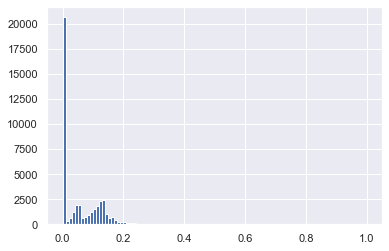

In [17]:
# We plot a histogram of a variable with 100 bins.
plt.hist(loan_data_defaults['recovery_rate'], bins = 100);

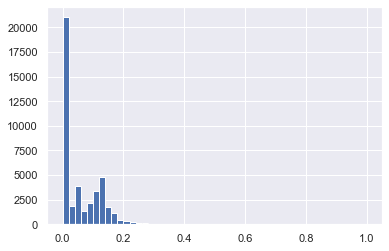

In [18]:
# We plot a histogram of a variable with 50 bins.
plt.hist(loan_data_defaults['recovery_rate'], bins = 50);

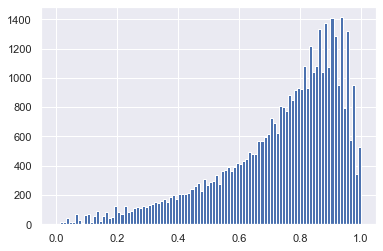

In [19]:
# We plot a histogram of a variable with 100 bins.
plt.hist(loan_data_defaults['CCF'], bins = 100);

In [20]:
# We create a new variable which is 0 if recovery rate is 0 and 1 otherwise.
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
loan_data_defaults['recovery_rate_0_1'].head()

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1     1
8     1
9     1
12    1
14    1
Name: recovery_rate_0_1, dtype: int32

<h2><a id="lgdmodel">5. LGD Model</a></h2>

[Index](#index)

[5.1 Split the data](#lgdmodel1)

[5.2 Estimating the Model](#lgdmodel2)

[5.3 Testing the Model](#lgdmodel3)

[5.4 Estimating the Аccuracy of the Мodel](#lgdmodel4)

[5.5 Saving the Model](#lgdmodel5)

[5.6 Stage 2 – Linear Regression](#lgdmodel6)

[5.7 Stage 2 – Linear Regression Evaluation](#lgdmodel7)

[5.8 Combining Stage 1 and Stage 2](#lgdmodel8)

<h3><a id="lgdmodel1">5.1 Split the data</a></h3>

[Top](#lgdmodel)

In [21]:
# LGD model stage 1 datasets: recovery rate 0 or greater than 0.
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(
    loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), 
    loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

In [22]:
# List of all independent variables for the models.
features_all = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 
                'home_ownership:MORTGAGE',  'home_ownership:NONE', 'home_ownership:OTHER', 'home_ownership:OWN', 
                'home_ownership:RENT',
                'verification_status:Not Verified',  'verification_status:Source Verified', 'verification_status:Verified',
                'purpose:car', 'purpose:credit_card', 'purpose:debt_consolidation', 'purpose:educational', 
                'purpose:home_improvement',  'purpose:house', 'purpose:major_purchase', 'purpose:medical', 
                'purpose:moving', 'purpose:other', 'purpose:renewable_energy', 'purpose:small_business', 
                'purpose:vacation', 'purpose:wedding', 
                'initial_list_status:f',  'initial_list_status:w',
                'term_int', 'emp_length_int', 'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt', 
                'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 
                'mths_since_last_record',  'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq', 'total_rev_hi_lim']

In [23]:
# List of the dummy variable reference categories. 
features_reference_cat = ['grade:G', 'home_ownership:RENT', 'verification_status:Verified', 'purpose:credit_card', 
                          'initial_list_status:f']

In [24]:
# Here we keep only the variables we need for the model.
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
# Here we remove the dummy variable reference categories
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

lgd_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

<h3><a id="lgdmodel2">5.2 Estimating the Model</a></h3>

[Top](#lgdmodel)

In [25]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [26]:
reg_lgd_st_1 = LogisticRegression_with_p_values()
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [27]:
feature_name = lgd_inputs_stage_1_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-7.858419e-05,NaN
1,grade:A,-9.574729e-06,9.999092e-01
2,grade:B,-6.451354e-05,9.992447e-01
3,grade:C,-1.301282e-04,9.984243e-01
4,grade:D,2.251628e-05,9.997383e-01
5,grade:E,1.574754e-05,9.998341e-01
6,grade:F,7.513450e-05,9.993115e-01
7,home_ownership:MORTGAGE,-3.540479e-05,9.988860e-01
8,home_ownership:NONE,9.142188e-07,9.999991e-01
9,home_ownership:OTHER,6.771630e-07,9.999986e-01


<h3><a id="lgdmodel3">5.3 Testing the Model</a></h3>

[Top](#lgdmodel)

In [28]:
# Here we keep only the variables we need for the model.
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

# Here we remove the dummy variable reference categories.
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 0, 1, 1])

In [29]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]
y_hat_test_proba_lgd_stage_1

array([0.60747376, 0.61161483, 0.45661867, ..., 0.49810765, 0.59260758,
       0.54358891])

In [30]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

# We reset the index of a dataframe.
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

# Concatenates two dataframes.
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], 
                                      axis = 1)
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.607474
69814,1,0.611615
101396,0,0.456619
463268,1,0.555712
253729,0,0.416937


<h3><a id="lgdmodel4">5.4 Estimating the Аccuracy of the Мodel</a></h3>

[Top](#lgdmodel)

In [31]:
tr = 0.5
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1']
                                                               > tr, 1, 0)

In [32]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
            rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

Predicted,0,1
Actual,,
0,980,2782
1,681,4205


In [33]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
            rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

Predicted,0,1
Actual,,
0,0.113321,0.321693
1,0.078747,0.486240


In [34]:
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (
    pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
                rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

0.5995605920444034

In [35]:
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.
# we store each of the three arrays in a separate variable.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'],
                                 df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

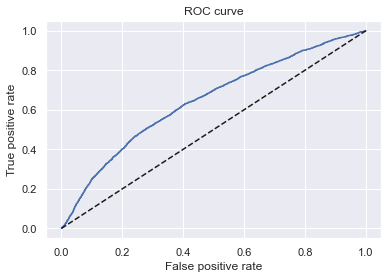

In [36]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [37]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], 
                      df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6465457078486787

<h3><a id="lgdmodel5">5.5 Saving the Model</a></h3>

[Top](#lgdmodel)

In [38]:
# Here we export our model to a 'SAV' file with file name 'lgd_model_stage_1.sav'.
pickle.dump(reg_lgd_st_1, open('..//Models//lgd_model_stage_1.sav', 'wb'))

<h3><a id="lgdmodel6">5.6 Stage 2 – Linear Regression</a></h3>

[Top](#lgdmodel)

In [39]:
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [40]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(
    lgd_stage_2_data.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1),
    lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)


In [41]:
# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: 
# https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1, positive=False):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs, positive=positive)
        self.positive = positive
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1, positive=False):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [42]:
# Here we keep only the variables we need for the model.
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [43]:
# Here we remove the dummy variable reference categories.
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [44]:
reg_lgd_st_2 = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


LinearRegression()

In [45]:
# Stores the names of the columns of a dataframe in a variable.
feature_name = lgd_inputs_stage_2_train.columns.values

In [46]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000
2,grade:B,-5.083556e-02,0.000
3,grade:C,-3.748066e-02,0.000
4,grade:D,-2.717310e-02,0.000
5,grade:E,-1.315941e-02,0.002
6,grade:F,-5.260168e-03,0.275
7,home_ownership:MORTGAGE,2.832212e-03,0.061
8,home_ownership:NONE,1.459035e-01,0.000
9,home_ownership:OTHER,-9.475922e-03,0.644


<h3><a id="lgdmodel7">5.7 Stage 2 – Linear Regression Evaluation</a></h3>

[Top](#lgdmodel)

In [47]:
# Here we keep only the variables we need for the model.
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

In [48]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [49]:
lgd_inputs_stage_2_test.columns.values
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [50]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [51]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [52]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [53]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


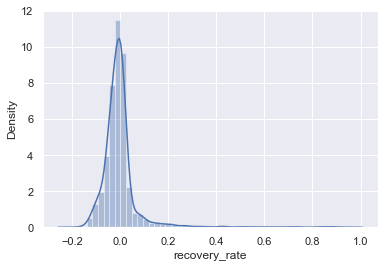

In [54]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2);
# We plot the distribution of the residuals.

In [55]:
pickle.dump(reg_lgd_st_2, open('..//Models//lgd_model_stage_2.sav', 'wb'))
# Here we export our model to a 'SAV' file with file name 'lgd_model_stage_1.sav'.

<h3><a id="lgdmodel8">5.8 Combining Stage 1 and Stage 2</a></h3>

[Top](#lgdmodel)

In [56]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [57]:
y_hat_test_lgd_stage_2_all

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

In [58]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all
# Here we combine the predictions of the models from the two stages.

In [59]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.087435
std,0.049838
min,-0.007634
25%,0.065592
50%,0.101282
75%,0.123657
max,0.236973


In [60]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [61]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.087437
std,0.049835
min,0.000000
25%,0.065592
50%,0.101282
75%,0.123657
max,0.236973


<h2><a id="eadmodel">6. EAD Model</a></h2>

[Index](#index)

[6.1 Estimation and Interpretation](#eadmodel1)

[6.2 Model Validation](#eadmodel2)

<h3><a id="eadmodel1">6.1 Estimation and Interpretation</a></h3>

[Top](#eadmodel)

In [62]:
# EAD model datasets
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop([
    'good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2,
                                                                                          random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [63]:
ead_inputs_train.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [64]:
ead_inputs_train = ead_inputs_train[features_all]
# Here we keep only the variables we need for the model.

In [65]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [66]:
reg_ead = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_ead.fit(ead_inputs_train, ead_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


LinearRegression()

In [67]:
feature_name = ead_inputs_train.columns.values

In [68]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,1.970424e-12
5,grade:E,-6.768713e-02,1.918578e-03
6,grade:F,-2.045907e-02,2.748685e-01
7,home_ownership:MORTGAGE,-6.343341e-03,6.050271e-02
8,home_ownership:NONE,-5.539064e-03,9.092582e-05
9,home_ownership:OTHER,-2.426052e-03,6.436926e-01


<h3><a id="eadmodel2">6.2 Model Validation</a></h3>

[Top](#eadmodel)

In [69]:
ead_inputs_test = ead_inputs_test[features_all]
# Here we keep only the variables we need for the model.

In [70]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [71]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [72]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [73]:
ead_targets_test_temp = ead_targets_test

In [74]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [75]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


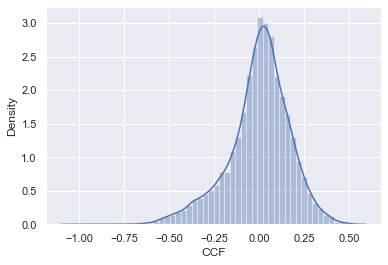

In [76]:
sns.distplot(ead_targets_test - y_hat_test_ead);
# We plot the distribution of the residuals.

In [77]:
pd.DataFrame(y_hat_test_ead).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [78]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [79]:
pd.DataFrame(y_hat_test_ead).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


<h2><a id="expectedloss">7. Expected Loss</a></h2>

[Index](#index)

In [80]:
loan_data_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [81]:
# We fill the missing values with zeroes.
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [82]:
# Here we keep only the variables we need for the model.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

In [83]:
# Here we remove the dummy variable reference categories.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [84]:
# We apply the stage 1 LGD model and calculate predicted values.
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [85]:
# We apply the stage 2 LGD model and calculate predicted values.
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [86]:
loan_data_preprocessed['recovery_rate'] = (loan_data_preprocessed['recovery_rate_st_1'] * 
                                           loan_data_preprocessed['recovery_rate_st_2'])
# We combine the predicted values from the stage 1 predicted model and the stage 2 predicted model
# to calculate the final estimated recovery rate.

In [87]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0,
                                                   loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1,
                                                   loan_data_preprocessed['recovery_rate'])
# We set estimated recovery rates that are greater than 1 to 1 and  estimated recovery rates that are less than 0 to 0.

In [88]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
# We calculate estimated LGD. Estimated LGD equals 1 - estimated recovery rate.

In [89]:
loan_data_preprocessed['LGD'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean          0.920012
std           0.057507
min           0.659786
25%           0.873105
50%           0.899027
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [90]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)
# We apply the EAD model to calculate estimated credit conversion factor.

In [91]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])
# We set estimated CCF that are greater than 1 to 1 and  estimated CCF that are less than 0 to 0.

In [92]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# We calculate estimated EAD. Estimated EAD equals estimated CCF multiplied by funded amount.

In [93]:
loan_data_preprocessed['EAD'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

In [94]:
loan_data_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,1,0,1,1,0.086271,0.086271,0.913729,0.589922,2949.608449
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,1,0,0,1,0.084518,0.084518,0.915482,0.777773,1944.433378
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,1,0,1,1,0.080516,0.080516,0.919484,0.658306,1579.934302
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,1,0,1,1,0.095076,0.095076,0.904924,0.660656,6606.559612
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,1,0,1,1,0.088547,0.088547,0.911453,0.708211,2124.631667


In [95]:
loan_data_inputs_train = pd.read_csv('../Data/loan_data_inputs_train.csv')
# We import data to apply the PD model.

In [96]:
loan_data_inputs_test = pd.read_csv('../Data/loan_data_inputs_test.csv')
# We import data to apply the PD model.

In [97]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
# We concatenate the two dataframes along the rows.

In [98]:
loan_data_inputs_pd.shape

(466285, 325)

In [99]:
loan_data_inputs_pd.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [100]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
# We set the index of the dataframe to the values of a specific column. 

In [101]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [102]:
features_all_pd = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 
                   'home_ownership:RENT_OTHER_NONE_ANY', 'home_ownership:OWN', 'home_ownership:MORTGAGE', 
                   'addr_state:ND_NE_IA_NV_FL_HI_AL', 'addr_state:NM_VA', 'addr_state:NY', 'addr_state:OK_TN_MO_LA_MD_NC',
                   'addr_state:CA', 'addr_state:UT_KY_AZ_NJ', 'addr_state:AR_MI_PA_OH_MN', 'addr_state:RI_MA_DE_SD_IN', 
                   'addr_state:GA_WA_OR',  'addr_state:WI_MT', 'addr_state:TX', 'addr_state:IL_CT', 
                   'addr_state:KS_SC_CO_VT_AK_MS', 'addr_state:WV_NH_WY_DC_ME_ID',
                   'verification_status:Not Verified', 'verification_status:Source Verified', 
                   'verification_status:Verified', 
                   'purpose:educ__sm_b__wedd__ren_en__mov__house', 'purpose:credit_card', 'purpose:debt_consolidation', 
                   'purpose:oth__med__vacation', 'purpose:major_purch__car__home_impr', 
                   'initial_list_status:f', 'initial_list_status:w', 
                   'term:36', 'term:60', 
                   'emp_length:0', 'emp_length:1', 'emp_length:2-4', 'emp_length:5-6', 'emp_length:7-9', 'emp_length:10', 
                   'mths_since_issue_d:<38', 'mths_since_issue_d:38-39', 'mths_since_issue_d:40-41', 
                   'mths_since_issue_d:42-48', 'mths_since_issue_d:49-52', 'mths_since_issue_d:53-64', 
                   'mths_since_issue_d:65-84', 'mths_since_issue_d:>84',
                   'int_rate:<9.548',  'int_rate:9.548-12.025', 'int_rate:12.025-15.74', 'int_rate:15.74-20.281', 
                   'int_rate:>20.281',
                   'mths_since_earliest_cr_line:<140', 'mths_since_earliest_cr_line:141-164', 
                   'mths_since_earliest_cr_line:165-247', 'mths_since_earliest_cr_line:248-270', 
                   'mths_since_earliest_cr_line:271-352', 'mths_since_earliest_cr_line:>352', 
                   'inq_last_6mths:0', 'inq_last_6mths:1-2', 'inq_last_6mths:3-6', 'inq_last_6mths:>6', 
                   'acc_now_delinq:0', 'acc_now_delinq:>=1',
                   'annual_inc:<20K', 'annual_inc:20K-30K', 'annual_inc:30K-40K', 'annual_inc:40K-50K', 
                   'annual_inc:50K-60K', 'annual_inc:60K-70K', 'annual_inc:70K-80K', 'annual_inc:80K-90K', 
                   'annual_inc:90K-100K', 'annual_inc:100K-120K', 'annual_inc:120K-140K', 'annual_inc:>140K', 
                   'dti:<=1.4', 'dti:1.4-3.5', 'dti:3.5-7.7', 'dti:7.7-10.5', 'dti:10.5-16.1', 'dti:16.1-20.3', 
                   'dti:20.3-21.7', 'dti:21.7-22.4', 'dti:22.4-35', 'dti:>35', 
                   'mths_since_last_delinq:Missing', 'mths_since_last_delinq:0-3',  'mths_since_last_delinq:4-30', 
                   'mths_since_last_delinq:31-56', 'mths_since_last_delinq:>=57', 'mths_since_last_record:Missing',
                   'mths_since_last_record:0-2', 'mths_since_last_record:3-20', 'mths_since_last_record:21-31', 
                   'mths_since_last_record:32-80', 'mths_since_last_record:81-86', 'mths_since_last_record:>86']

In [103]:
ref_categories_pd = ['grade:G', 'home_ownership:RENT_OTHER_NONE_ANY', 'addr_state:ND_NE_IA_NV_FL_HI_AL', 
                     'verification_status:Verified', 'purpose:educ__sm_b__wedd__ren_en__mov__house', 
                     'initial_list_status:f', 'term:60', 'emp_length:0', 'mths_since_issue_d:>84', 'int_rate:>20.281', 
                     'mths_since_earliest_cr_line:<140', 'inq_last_6mths:>6', 'acc_now_delinq:0', 'annual_inc:<20K', 
                     'dti:>35', 'mths_since_last_delinq:0-3', 'mths_since_last_record:0-2']

In [104]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
# Here we keep only the variables we need for the model.

In [105]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)
# Here we remove the dummy variable reference categories.

In [106]:
loan_data_inputs_pd_temp.shape

(466285, 84)

In [107]:
reg_pd = pickle.load(open('..//Models//pd_model.sav', 'rb'))
# We import the PD model, stored in the 'pd_model.sav' file.

In [108]:
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# We apply the PD model to caclulate estimated default probabilities.

array([0.02958565, 0.09214845, 0.03735921, ..., 0.02678664, 0.04020868,
       0.04763351])

In [109]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# We apply the PD model to caclulate estimated default probabilities.

In [110]:
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427211    0.029586
206088    0.092148
136020    0.037359
412305    0.204327
36159     0.200848
Name: PD, dtype: float64

In [111]:
loan_data_inputs_pd['PD'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean          0.109307
std           0.070917
min           0.007314
25%           0.056064
50%           0.093492
75%           0.146558
max           0.635816
Name: PD, dtype: float64

In [112]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)
# We concatenate the dataframes where we calculated LGD and EAD and the dataframe where we calculated PD along the columns.

In [113]:
loan_data_preprocessed_new.shape

(466285, 540)

In [114]:
loan_data_preprocessed_new.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,PD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,1,0,1,0,0,0,0,0,0,0.164761
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,1,0,0,0,0,0,0,0.282341
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,1,0,0,0,0,0,0,0.229758
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,1,0,0,0,0,0,0,0.208893
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,1,0,0,0,0,0,0,0.129556


In [115]:
loan_data_preprocessed_new['EL'] = (loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * 
                                    loan_data_preprocessed_new['EAD'])
# We calculate Expected Loss. EL = PD * LGD * EAD.

In [116]:
loan_data_preprocessed_new['EL'].describe()
# Shows some descriptive statisics for the values of a column.

count    466285.000000
mean       1075.065867
std        1090.550566
min           9.543111
25%         355.626885
50%         704.991961
75%        1393.950550
max       11909.912730
Name: EL, dtype: float64

In [117]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.164761,0.913729,2949.608449,444.053348
1,2500,2500,0.282341,0.915482,1944.433378,502.592542
2,2400,2400,0.229758,0.919484,1579.934302,333.775101
3,10000,10000,0.208893,0.904924,6606.559612,1248.855699
4,3000,3000,0.129556,0.911453,2124.631667,250.886113


In [118]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [119]:
loan_data_preprocessed_new['EL'].sum()
# Total Expected Loss for all loans.

501287087.74919593

In [120]:
loan_data_preprocessed_new['funded_amnt'].sum()
# Total funded amount for all loans.

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

In [121]:
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()
# Total Expected Loss as a proportion of total funded amount for all loans.

funded_amnt    0.075223
funded_amnt    0.075223
dtype: float64